In [2]:
import pandas as pd
import glob


In [5]:
import os
os.getcwd()


'C:\\Users\\THRISHUL SHETTY\\youtube_comment_analysis'

In [8]:
import os
os.getcwd()


'C:\\Users\\THRISHUL SHETTY\\youtube_comment_analysis\\youtube_comments'

In [9]:
os.listdir()


['.ipynb_checkpoints',
 'CAvideos.csv',
 'CA_category_id.json',
 'DEvideos.csv',
 'DE_category_id.json',
 'FRvideos.csv',
 'FR_category_id.json',
 'GBvideos.csv',
 'GB_category_id.json',
 'INvideos.csv',
 'IN_category_id.json',
 'JPvideos.csv',
 'JP_category_id.json',
 'KRvideos.csv',
 'KR_category_id.json',
 'MXvideos.csv',
 'MX_category_id.json',
 'RUvideos.csv',
 'RU_category_id.json',
 'USvideos.csv',
 'US_category_id.json',
 'youtube_sentiment_analysis.ipynb']

In [10]:
import pandas as pd
import glob

# get all video csv files
all_files = glob.glob("*videos.csv")

print(all_files)   # sanity check


['CAvideos.csv', 'DEvideos.csv', 'FRvideos.csv', 'GBvideos.csv', 'INvideos.csv', 'JPvideos.csv', 'KRvideos.csv', 'MXvideos.csv', 'RUvideos.csv', 'USvideos.csv']


In [15]:
import pandas as pd
import glob

all_files = glob.glob("*videos.csv")

df_list = []

for file in all_files:
    temp_df = pd.read_csv(
        file,
        encoding='latin1',   # KEY FIX
        on_bad_lines='skip'
    )
    
    country = file[:2]
    temp_df['country'] = country
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)


In [14]:
df.shape


(375942, 17)

In [16]:
df['country'].value_counts()


country
US    40949
CA    40881
DE    40840
RU    40739
FR    40724
MX    40451
GB    38916
IN    37352
KR    34567
JP    20523
Name: count, dtype: int64

In [17]:
df = df[['title', 'country']]
df.head()


,title,country
0,Eminem - Walk On Water (Audio) ft. BeyoncÃ©,CA
1,PLUSH - Bad Unboxing Fan Mail,CA
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",CA
3,I Dare You: GOING BALD!?,CA
4,Ed Sheeran - Perfect (Official Music Video),CA


In [19]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 1   # Positive
    elif score <= -0.05:
        return 0   # Negative
    else:
        return 2   # Neutral


[nltk_data] Downloading package vader_lexicon to C:\Users\THRISHUL
[nltk_data]     SHETTY\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
df['sentiment'] = df['title'].apply(get_sentiment)


In [21]:
df['sentiment'].value_counts()


sentiment
2    281321
1     51141
0     43480
Name: count, dtype: int64

In [22]:
df = df.sample(100000, random_state=42)
df.shape


(100000, 3)

In [24]:
min_count = df['sentiment'].value_counts().min()
min_count


11532

In [25]:
df = df.groupby('sentiment').sample(
    n=min_count,
    random_state=42
)

df['sentiment'].value_counts()


sentiment
0    11532
1    11532
2    11532
Name: count, dtype: int64

In [28]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df['clean_title'] = df['title'].apply(clean_text)


[nltk_data] Downloading package punkt to C:\Users\THRISHUL
[nltk_data]     SHETTY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\THRISHUL
[nltk_data]     SHETTY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to C:\Users\THRISHUL
[nltk_data]     SHETTY\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [31]:
df[['title', 'clean_title']].head()


,title,clean_title
79515,Crime Patrol Dial 100 - Ep 789 - Full Episode ...,crime patrol dial ep full episode st may
186081,Mind is Blind ft. Gaurav Arora | Raahii Films ...,mind blind ft gaurav arora raahii films harshd...
172847,Villagers attack on CM Nitish Kumar's convoy i...,villagers attack cm nitish kumars convoy bihar...
8197,Ellen DeGeneres LOSES IT With Audience Member,ellen degeneres loses audience member
350859,Why Don't We - Trust Fund Baby (Official Audio),dont trust fund baby official audio


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)   # unigrams + bigrams
)

X = vectorizer.fit_transform(df['clean_title'])
y = df['sentiment']


In [33]:
X.shape


(34596, 5000)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [35]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [36]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8848265895953757
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2306
           1       0.92      0.89      0.91      2307
           2       0.83      0.92      0.87      2307

    accuracy                           0.88      6920
   macro avg       0.89      0.88      0.89      6920
weighted avg       0.89      0.88      0.89      6920



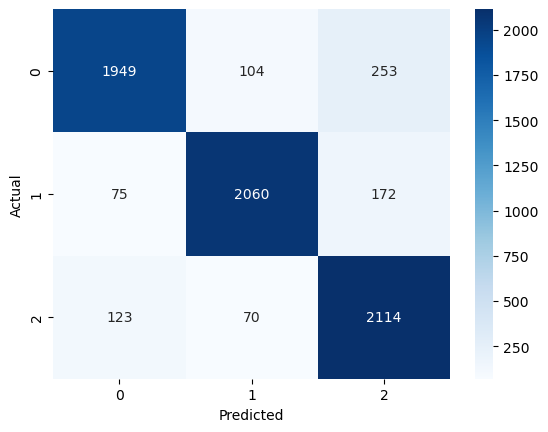

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [39]:
country_sentiment = (
    df.groupby(['country', 'sentiment'])
    .size()
    .unstack()
    .fillna(0)
)

country_sentiment.columns = ['Negative', 'Positive', 'Neutral']
country_sentiment


,Negative,Positive,Neutral
country,,,
CA,2289,2022,954
DE,1610,992,1271
FR,752,937,1329
GB,2007,1993,923
IN,1230,1714,1032
JP,136,160,832
KR,186,299,1363
MX,1100,755,1330
RU,147,210,1611


In [41]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


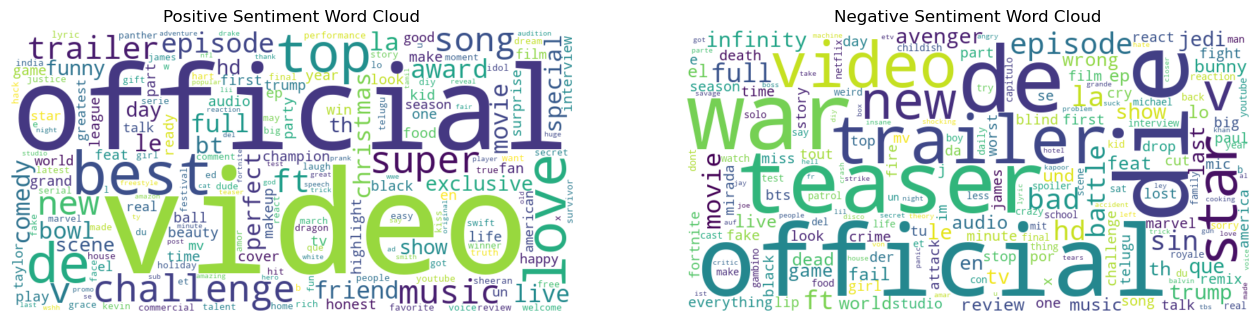

In [42]:


from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine text by sentiment
positive_text = " ".join(df[df['sentiment'] == 1]['clean_title'].dropna())
negative_text = " ".join(df[df['sentiment'] == 0]['clean_title'].dropna())

# Create word clouds
wc_positive = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations=False
).generate(positive_text)

wc_negative = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations=False
).generate(negative_text)

# Plot both word clouds
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Sentiment Word Cloud")

plt.subplot(1,2,2)
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Sentiment Word Cloud")

plt.show()
